In [1]:
import os
import shutil
import gdown
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from xml.etree import ElementTree
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torchinfo import summary


/home/arch/ObjDct_Repo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_data_path = "raw_data"

In [3]:
if os.path.exists(raw_data_path):
    print('[INFO] Raw data directory exists, skiping download.')
else:
    os.makedirs(raw_data_path)
    print('[INFO] Raw data directory is been created.')
    print('[INFO] Downloading data...\n')
    gdown.download('https://drive.google.com/uc?id=1KoQzqR20qvIXDf1qsXCHGxD003IPmXMw', output=os.path.join(raw_data_path, 'Annotations.zip'))
    gdown.download('https://drive.google.com/file/d/1wq0FQCBsbrnf-sJfloi7IR9tBH87GGGS/view?usp=sharing', output=os.path.join(raw_data_path, 'JPEGImages-test.zip'),fuzzy=True)
    gdown.download('https://drive.google.com/file/d/1NVRSBm3RfpGGtZvgLJG5e_XD9uP4DZmI/view?usp=sharing', output=os.path.join(raw_data_path, 'JPEGImages-trainval.zip'),fuzzy=True)
    print('[INFO] Data is been downloaded.')

[INFO] Raw data directory is been created.
[INFO] Downloading data...



Downloading...
From (original): https://drive.google.com/uc?id=1KoQzqR20qvIXDf1qsXCHGxD003IPmXMw
From (redirected): https://drive.google.com/uc?id=1KoQzqR20qvIXDf1qsXCHGxD003IPmXMw&confirm=t&uuid=d0ed2b9c-4b12-403d-a604-d78844b77f2c
To: /home/arch/ObjDct_Repo/raw_data/Annotations.zip
100%|██████████| 32.1M/32.1M [00:00<00:00, 105MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1wq0FQCBsbrnf-sJfloi7IR9tBH87GGGS
From (redirected): https://drive.google.com/uc?id=1wq0FQCBsbrnf-sJfloi7IR9tBH87GGGS&confirm=t&uuid=116b99e5-8822-4354-8135-1dc991631fe3
To: /home/arch/ObjDct_Repo/raw_data/JPEGImages-test.zip
100%|██████████| 3.52G/3.52G [01:14<00:00, 47.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1NVRSBm3RfpGGtZvgLJG5e_XD9uP4DZmI
From (redirected): https://drive.google.com/uc?id=1NVRSBm3RfpGGtZvgLJG5e_XD9uP4DZmI&confirm=t&uuid=9e9f2e9d-4bb3-4043-af3e-441bba18675a
To: /home/arch/ObjDct_Repo/raw_data/JPEGImages-trainval.zip
100%|██████████| 3.88G/3.88

[INFO] Data is been downloaded.


In [4]:
dior_data_path = "dior_data"

In [5]:
# Extracting the zip data files
if os.path.exists(dior_data_path):
    print('[INFO] DIOR data directory exists, skiping extraction.')
else:
    os.makedirs(dior_data_path)
    for i in os.listdir(raw_data_path):
        filename = os.path.join(raw_data_path, i) 
        shutil.unpack_archive(filename=filename, extract_dir=dior_data_path)
        print(f'[INFO] File "{filename}" is been extracted to "{dior_data_path}".')

[INFO] File "raw_data/JPEGImages-trainval.zip" is been extracted to "dior_data".
[INFO] File "raw_data/Annotations.zip" is been extracted to "dior_data".
[INFO] File "raw_data/JPEGImages-test.zip" is been extracted to "dior_data".


In [6]:
# Path for all the data
annot_data_path = 'dior_data/Annotations/Horizontal Bounding Boxes'
trainval_data_path = 'dior_data/JPEGImages-trainval'
test_data_path = 'dior_data/JPEGImages-test'

In [7]:
# Creating a list of annotation files
annot_file_list = sorted([os.path.join(annot_data_path, i) for i in os.listdir(annot_data_path) if '.xml' in i])
annot_file_list[:5], annot_file_list[-5:], len(annot_file_list)

(['dior_data/Annotations/Horizontal Bounding Boxes/00001.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/00002.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/00003.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/00004.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/00005.xml'],
 ['dior_data/Annotations/Horizontal Bounding Boxes/23459.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/23460.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/23461.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/23462.xml',
  'dior_data/Annotations/Horizontal Bounding Boxes/23463.xml'],
 23463)

In [8]:
# Creating a list of training and validation images
trainval_file_list = sorted([os.path.join(trainval_data_path, i) for i in os.listdir(trainval_data_path) if '.jpg' in i])
trainval_file_list[:5], trainval_file_list[-5:], len(trainval_file_list)

(['dior_data/JPEGImages-trainval/00001.jpg',
  'dior_data/JPEGImages-trainval/00002.jpg',
  'dior_data/JPEGImages-trainval/00003.jpg',
  'dior_data/JPEGImages-trainval/00004.jpg',
  'dior_data/JPEGImages-trainval/00005.jpg'],
 ['dior_data/JPEGImages-trainval/11721.jpg',
  'dior_data/JPEGImages-trainval/11722.jpg',
  'dior_data/JPEGImages-trainval/11723.jpg',
  'dior_data/JPEGImages-trainval/11724.jpg',
  'dior_data/JPEGImages-trainval/11725.jpg'],
 11725)

In [9]:
# Creating a list of testing images
test_file_list = sorted([os.path.join(test_data_path, i) for i in os.listdir(test_data_path) if '.jpg' in i])
test_file_list[:5], test_file_list[-5:], len(test_file_list)

(['dior_data/JPEGImages-test/11726.jpg',
  'dior_data/JPEGImages-test/11727.jpg',
  'dior_data/JPEGImages-test/11728.jpg',
  'dior_data/JPEGImages-test/11729.jpg',
  'dior_data/JPEGImages-test/11730.jpg'],
 ['dior_data/JPEGImages-test/23459.jpg',
  'dior_data/JPEGImages-test/23460.jpg',
  'dior_data/JPEGImages-test/23461.jpg',
  'dior_data/JPEGImages-test/23462.jpg',
  'dior_data/JPEGImages-test/23463.jpg'],
 11738)

In [10]:
# Combining all the images path in one list
image_data_file_list = np.concatenate((trainval_file_list, test_file_list))
image_data_file_list[:5], image_data_file_list[-5:], len(image_data_file_list)

(array(['dior_data/JPEGImages-trainval/00001.jpg',
        'dior_data/JPEGImages-trainval/00002.jpg',
        'dior_data/JPEGImages-trainval/00003.jpg',
        'dior_data/JPEGImages-trainval/00004.jpg',
        'dior_data/JPEGImages-trainval/00005.jpg'], dtype='<U39'),
 array(['dior_data/JPEGImages-test/23459.jpg',
        'dior_data/JPEGImages-test/23460.jpg',
        'dior_data/JPEGImages-test/23461.jpg',
        'dior_data/JPEGImages-test/23462.jpg',
        'dior_data/JPEGImages-test/23463.jpg'], dtype='<U39'),
 23463)

In [11]:
# Extracting data from annotation files
meta_list = [] # To store general info for every image
object_list_train = [] # To store object classes info of train dataset
object_list_test = [] # To store object classes info of test dataset

for file in tqdm(annot_file_list):
    meta_dict = {}
    root = ElementTree.parse(file).getroot()
    
    # Filename - extracted
    for path in image_data_file_list:
        if root.find('filename').text in path:
            meta_dict['filename'] = path
            meta_dict['split_type'] = path.split('/')[1]
    
    # Width - extracted
    meta_dict['width'] = int(root.find('size').find('width').text)
    
    # Height - extracted
    meta_dict['height'] = int(root.find('size').find('height').text)
    
    # Objects - extracted and combined into a single string
    meta_dict['objects'] = ', '.join(np.unique([obj.find('name').text for obj in root.findall('object')]))
    meta_list.append(meta_dict)
    
    # Collecting all the object classes instance and counting total appearance
    for obj in root.findall('object'):
        if meta_dict['split_type'] == 'JPEGImages-trainval':
            object_list_train.append(obj.find('name').text)
        elif meta_dict['split_type'] == 'JPEGImages-test':
            object_list_test.append(obj.find('name').text)
    
# Counting the instance for every object class
object_instance_list_train = Counter(sorted(object_list_train))
object_instance_list_test = Counter(sorted(object_list_test))
    
# Collecting Class list and indexing it also in a sequence
class_dict = {k: v for v, k in enumerate(sorted(np.unique(object_list_train)))}

meta_list[:5], object_instance_list_train, object_instance_list_test, class_dict

  0%|          | 0/23463 [00:00<?, ?it/s]

100%|██████████| 23463/23463 [03:47<00:00, 103.14it/s]


([{'filename': 'dior_data/JPEGImages-trainval/00001.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'golffield'},
  {'filename': 'dior_data/JPEGImages-trainval/00002.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'Expressway-toll-station, vehicle'},
  {'filename': 'dior_data/JPEGImages-trainval/00003.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'trainstation'},
  {'filename': 'dior_data/JPEGImages-trainval/00004.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'chimney'},
  {'filename': 'dior_data/JPEGImages-trainval/00005.jpg',
   'split_type': 'JPEGImages-trainval',
   'width': 800,
   'height': 800,
   'objects': 'storagetank, vehicle'}],
 Counter({'ship': 27351,
          'vehicle': 13725,
          'tenniscourt': 4898,
          'storagetank': 3042,
          'baseballfield': 2384,
          '

In [12]:
# Creating a dataframe from the extracted data
meta_df = pd.DataFrame(meta_list)
meta_df

,filename,split_type,width,height,objects
0,dior_data/JPEGImages-trainval/00001.jpg,JPEGImages-trainval,800,800,golffield
1,dior_data/JPEGImages-trainval/00002.jpg,JPEGImages-trainval,800,800,"Expressway-toll-station, vehicle"
2,dior_data/JPEGImages-trainval/00003.jpg,JPEGImages-trainval,800,800,trainstation
3,dior_data/JPEGImages-trainval/00004.jpg,JPEGImages-trainval,800,800,chimney
4,dior_data/JPEGImages-trainval/00005.jpg,JPEGImages-trainval,800,800,"storagetank, vehicle"
...,...,...,...,...,...
23458,dior_data/JPEGImages-test/23459.jpg,JPEGImages-test,800,800,vehicle
23459,dior_data/JPEGImages-test/23460.jpg,JPEGImages-test,800,800,"groundtrackfield, tenniscourt, vehicle"
23460,dior_data/JPEGImages-test/23461.jpg,JPEGImages-test,800,800,"overpass, vehicle"
23461,dior_data/JPEGImages-test/23462.jpg,JPEGImages-test,800,800,"overpass, vehicle"


In [13]:
print(f'Size of the images width: {meta_df.width.unique()[0]} and height: {meta_df.height.unique()[0]}')
print(f'Total number of classes with all possible combination: {len(meta_df.objects.unique())}')
print(f'Total length of the training/validation dataset: {len(meta_df[meta_df["split_type"] == "JPEGImages-trainval"])} and testing dataset: {len(meta_df[meta_df["split_type"] == "JPEGImages-test"])}')

Size of the images width: 800 and height: 800
Total number of classes with all possible combination: 526
Total length of the training/validation dataset: 11725 and testing dataset: 11738


Text(0.5, 1.0, 'Top 20 Objects Classes')

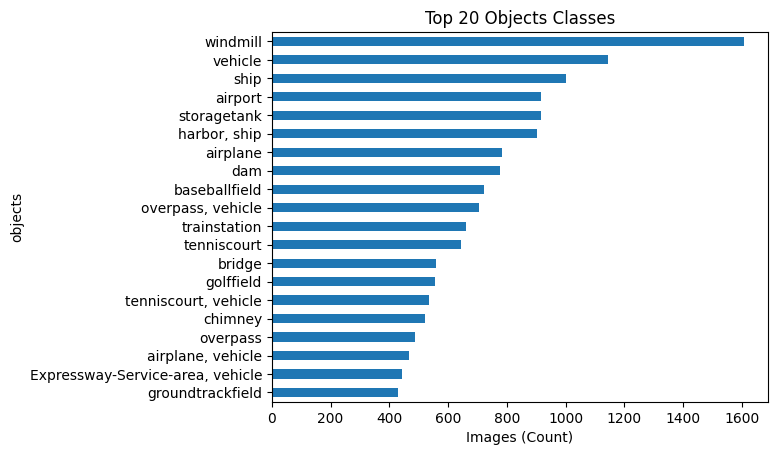

In [14]:
# Top 20 classes in the dataset
meta_df.objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Top 20 Objects Classes')

Text(0.5, 0.98, 'Top 20 Objects Classes in the Dataset')

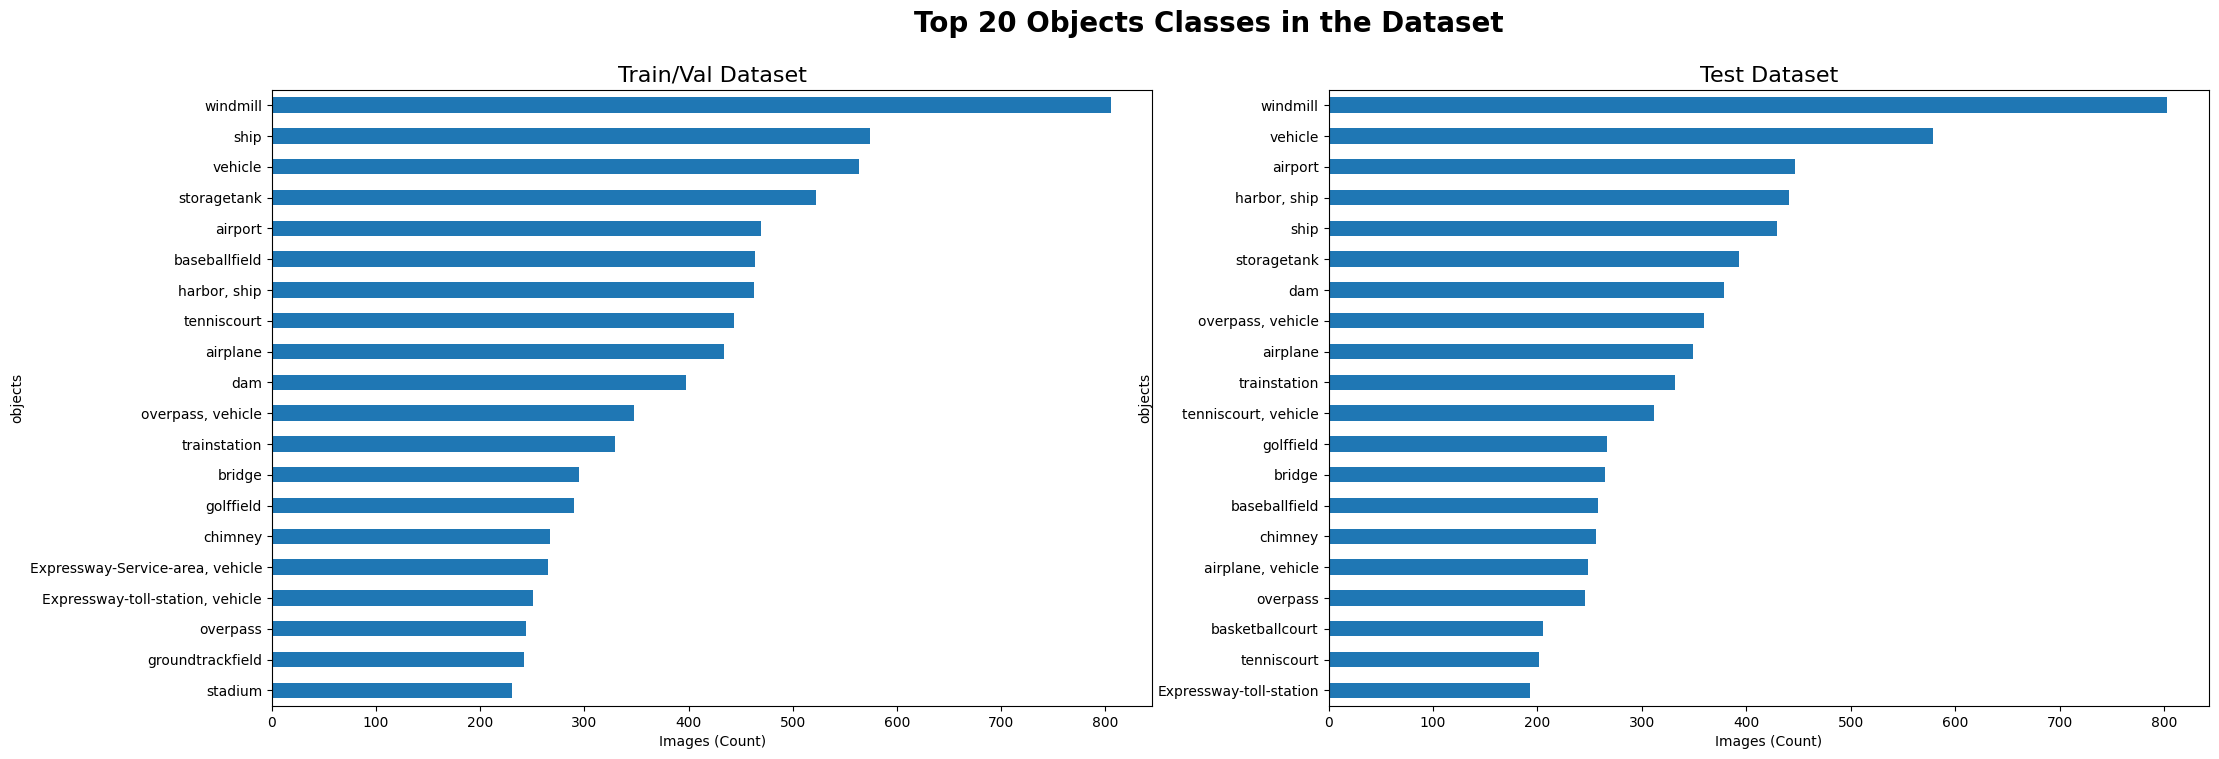

In [15]:
plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
meta_df[meta_df["split_type"] == "JPEGImages-trainval"].objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Train/Val Dataset', fontsize=16)
plt.subplot(1, 2, 2)
meta_df[meta_df["split_type"] == "JPEGImages-test"].objects.value_counts()[:20].plot(kind='barh').invert_yaxis()
plt.xlabel('Images (Count)')
plt.title('Test Dataset', fontsize=16)
plt.suptitle('Top 20 Objects Classes in the Dataset', fontsize=20, fontweight='bold')

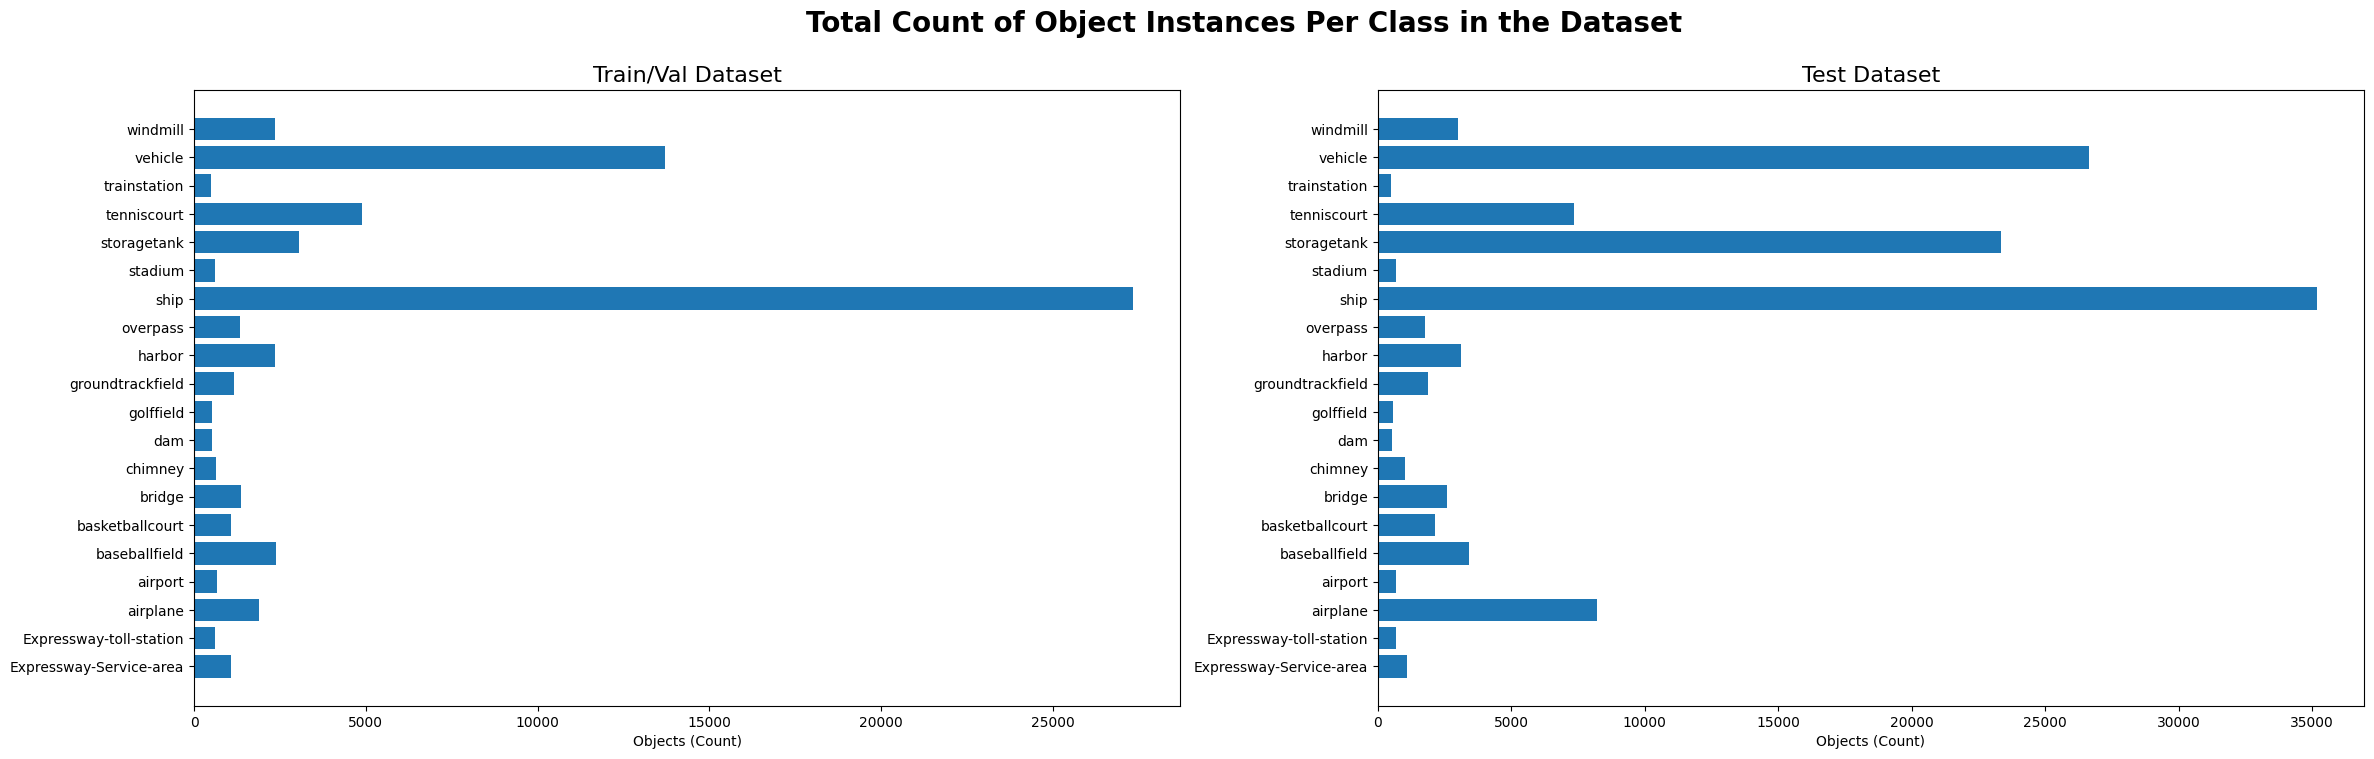

In [16]:
plt.figure(figsize=(28, 8))
plt.subplot(1, 2, 1)
plt.barh(list(object_instance_list_train.keys()), list(object_instance_list_train.values()))
plt.xlabel('Objects (Count)')
plt.title('Train/Val Dataset', fontsize=16)
plt.subplot(1, 2, 2)
plt.barh(list(object_instance_list_test.keys()), list(object_instance_list_test.values()))
plt.xlabel('Objects (Count)')
plt.title('Test Dataset', fontsize=16)
plt.suptitle('Total Count of Object Instances Per Class in the Dataset', fontsize=20, fontweight='bold');

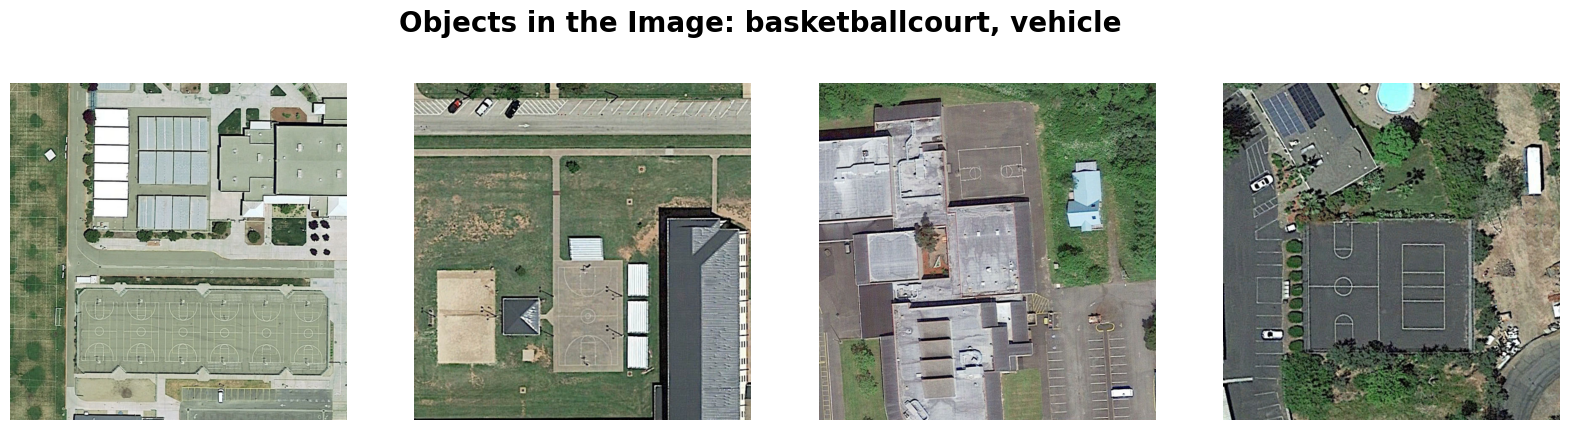

In [17]:
# Visualizing the classes - rerun the code for different classes.
viz_class = random.sample(meta_df.objects.tolist(), 1)[0]
viz_list = meta_df[meta_df['objects'] == viz_class].filename.tolist()
plt.figure(figsize=(20, 5))
rand = random.sample(viz_list, 4)
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(plt.imread(rand[i]))
    plt.suptitle(f'Objects in the Image: {viz_class}', fontsize=20, fontweight='bold')
    plt.axis(False)

In [18]:
# Creating a function for extracting data
def extract_data_from_xml(xml_file: str):
    """
    A function to extract data like filename, size, classes and bboxes from xml file.
    
    Parameters: xml_file: str, A string containing the path to the file.
    
    Returns: data_dict: dict, A dict containing all the extracted data.
    """
    root = ElementTree.parse(xml_file).getroot()
    
    # Creating dict and list to store data
    data_dict = {}
    data_dict['bboxes'] = []
    
    # Reading the xml file
    for element in root:
        # Getting the filename
        if element.tag == 'filename':
            data_dict['filename'] = element.text
        
        # Getting the image size
        elif element.tag == 'size':
            image_size = []
            for size_element in element:
                image_size.append(int(size_element.text))
            data_dict['image_size'] = image_size
        
        # Getting the bounding box
        elif element.tag == 'object':
            bbox = {}
            for obj_element in element:
                # Object or Class name
                if obj_element.tag == 'name':
                    bbox['class'] = obj_element.text
                # Object bounding box 
                elif obj_element.tag == 'bndbox':
                    for bbox_element in obj_element:
                        bbox[bbox_element.tag] = int(bbox_element.text)
            data_dict['bboxes'].append(bbox)
    return data_dict

In [19]:
example = extract_data_from_xml(annot_file_list[1])
example

{'bboxes': [{'class': 'Expressway-toll-station',
   'xmin': 231,
   'ymin': 221,
   'xmax': 303,
   'ymax': 304},
  {'class': 'vehicle', 'xmin': 49, 'ymin': 231, 'xmax': 67, 'ymax': 242},
  {'class': 'vehicle', 'xmin': 54, 'ymin': 252, 'xmax': 72, 'ymax': 262},
  {'class': 'vehicle', 'xmin': 297, 'ymin': 227, 'xmax': 316, 'ymax': 239}],
 'filename': '00002.jpg',
 'image_size': [800, 800, 3]}

In [20]:
# Creating a function to create a YOLO format annotation
def convert_dict_to_yolo(data_dict: dict):
    """
    A function to convert the extracted data dict into a text file as per the YOLO format.
    The final text file is saved in the directory "dior_data/yolo_annotations/data_dict['filename'].txt".
    
    Parameters: data_dict: dict, A dict containing the data.
    """
    data = []
    
    # Reading the bounding box data
    for bbox in data_dict['bboxes']:
        try:
            class_id = class_dict[bbox['class']]
        except KeyError:
            print(f'Invalid Class. Object class: "{bbox["class"]}" not present in the class list.')
            
        # Transforming the bbox in Yolo format [X, Y, W, H]
        img_w, img_h, _ = data_dict['image_size'] # Normalizing the bbox using image size
        
        x_center = ((bbox['xmin'] + bbox['xmax']) / 2) / img_w
        y_center = ((bbox['ymin'] + bbox['ymax']) / 2) / img_h
        width = (bbox['xmax'] - bbox['xmin']) / img_w 
        height = (bbox['ymax'] - bbox['ymin']) / img_h
        
        # Writing the new data to the data list in Yolo format
        data.append(f'{class_id} {x_center:.3f} {y_center:.3f} {width:.3f} {height:.3f}')
        
    # File name for saving the text file(same as xml and jpg file name)
    yolo_annot_dir = os.path.join('dior_data', 'yolo_annotations')
    if not os.path.exists(yolo_annot_dir):
        os.makedirs(yolo_annot_dir)
    save_file_name = os.path.join(yolo_annot_dir, data_dict['filename'].replace('jpg', 'txt'))
    
    # Saving the yolo annotation in a text file
    f = open(save_file_name, 'w+')
    f.write('\n'.join(data))
    f.close()

In [21]:
# Converting all the xml files into Yolo format text files
print('[INFO] Annotation extraction and creation into Yolo has started.')
for annot_file in tqdm(annot_file_list):
    data_dict = extract_data_from_xml(annot_file)
    convert_dict_to_yolo(data_dict)
print('[INFO] All the annotation are converted into Yolo format.')

[INFO] Annotation extraction and creation into Yolo has started.


100%|██████████| 23463/23463 [00:04<00:00, 4937.25it/s]

[INFO] All the annotation are converted into Yolo format.


In [22]:
yolo_annot_path = 'dior_data/yolo_annotations'
yolo_annot_file_list = sorted([os.path.join(yolo_annot_path, i) for i in os.listdir(yolo_annot_path) if '.txt' in i])
yolo_annot_file_list[:5], yolo_annot_file_list[-5:], len(yolo_annot_file_list)

(['dior_data/yolo_annotations/00001.txt',
  'dior_data/yolo_annotations/00002.txt',
  'dior_data/yolo_annotations/00003.txt',
  'dior_data/yolo_annotations/00004.txt',
  'dior_data/yolo_annotations/00005.txt'],
 ['dior_data/yolo_annotations/23459.txt',
  'dior_data/yolo_annotations/23460.txt',
  'dior_data/yolo_annotations/23461.txt',
  'dior_data/yolo_annotations/23462.txt',
  'dior_data/yolo_annotations/23463.txt'],
 23463)

In [23]:
class_dict_idx = dict(zip(class_dict.values(), class_dict.keys()))
class_dict_idx

{0: 'Expressway-Service-area',
 1: 'Expressway-toll-station',
 2: 'airplane',
 3: 'airport',
 4: 'baseballfield',
 5: 'basketballcourt',
 6: 'bridge',
 7: 'chimney',
 8: 'dam',
 9: 'golffield',
 10: 'groundtrackfield',
 11: 'harbor',
 12: 'overpass',
 13: 'ship',
 14: 'stadium',
 15: 'storagetank',
 16: 'tenniscourt',
 17: 'trainstation',
 18: 'vehicle',
 19: 'windmill'}

In [24]:
def plot_bboxes(img_file: str, annot_file: str, class_dict: dict):
    """
    A function to plot the bounding boxes amd their object classes onto the image.
    
    Parameters:
        img_file: str, A string containing the path to the image file.
        annot_file: str, A string containing the path to the annotation file in yolo format.
        class_dict: dict, A dict containing the classes in the similar sequence as per the annot_file.
    """
    # Reading the image and annot file
    image = cv2.imread(img_file)
    img_h, img_w, _ = image.shape
    
    with open(annot_file, 'r') as f:
        data = f.read().split('\n')
        data = [i.split(' ') for i in data]
        data = [[float(j) for j in i] for i in data]
    
    # Calculating the bbox in Pascal VOC format
    for bbox in data:
        class_idx, x_center, y_center, width, height = bbox
        xmin = int((x_center - width / 2) * img_w)
        ymin = int((y_center - height / 2) * img_h)
        xmax = int((x_center + width / 2) * img_w)
        ymax = int((y_center + height / 2) * img_h)
        
        # Correcting bbox if out of image size
        if xmin < 0:
            xmin = 0
        if ymin < 0:
            ymin = 0
        if xmax > img_w - 1:
            xmax = img_w - 1
        if ymax > img_h - 1:
            ymax = img_h - 1
        
        # Creating the box and label for the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 255, 0), 2)
        cv2.putText(image, class_dict[class_idx], (xmin, 0 if ymin-10 < 0 else ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
    
    # Displaying the image
    plt.imshow(image)
    plt.axis(False)

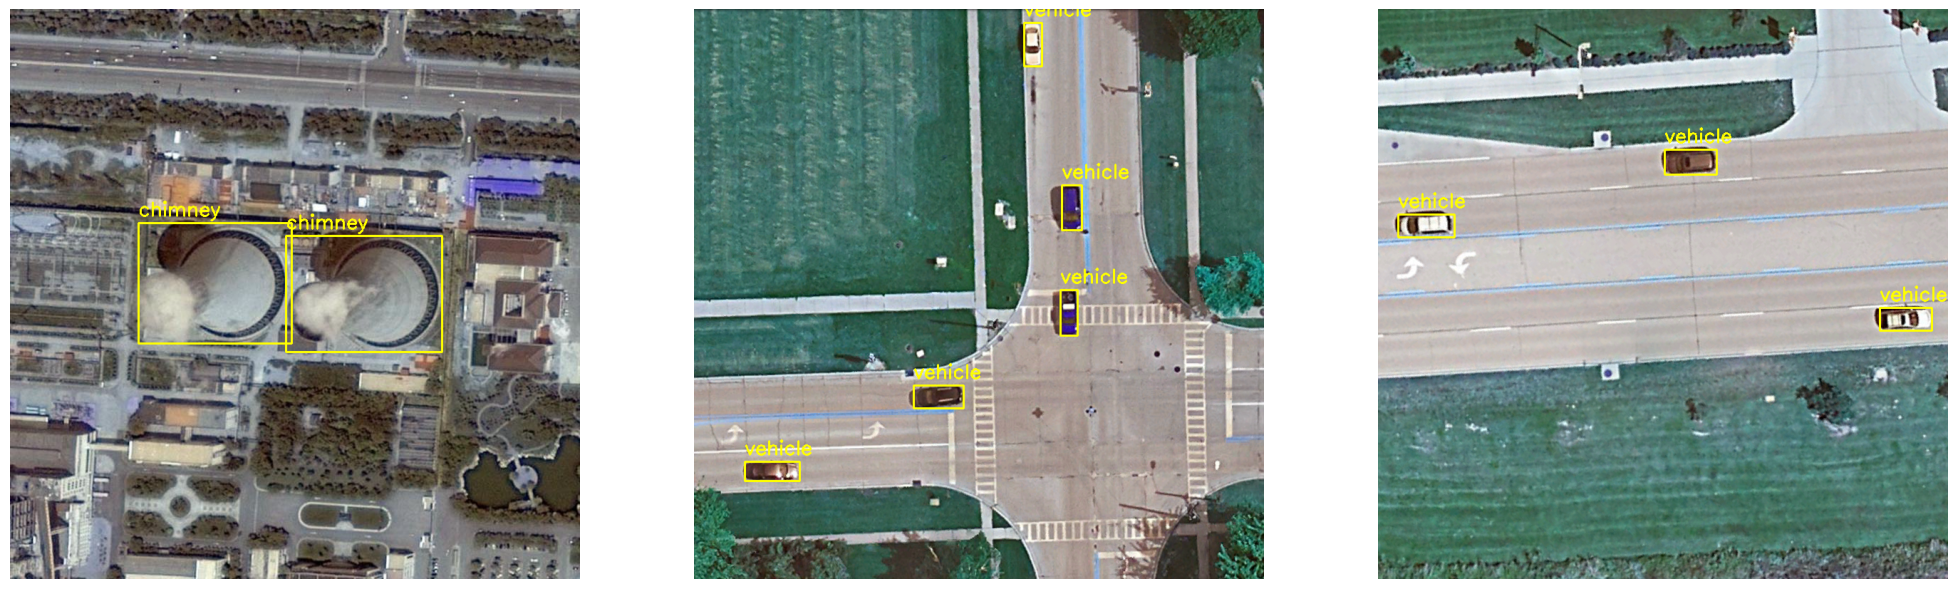

In [25]:
plt.figure(figsize=(25, 8))
rand_int = random.sample(range(len(yolo_annot_file_list)), 3)
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_bboxes(image_data_file_list[rand_int[i]], yolo_annot_file_list[rand_int[i]], class_dict_idx)

In [29]:
# Creating images and labels directory into the data directory
root_dir = 'dataset'
image_dir = 'dataset/images'
label_dir = 'dataset/labels'
img_train_dir = 'dataset/images/train'
label_train_dir = 'dataset/labels/train'
img_test_dir = 'dataset/images/test'
label_test_dir = 'dataset/labels/test'


In [30]:
# Moving the training labels
if not os.path.exists(label_train_dir):
    os.makedirs(label_train_dir)
    os.makedirs(img_train_dir)

for filepath in tqdm(trainval_file_list):
    label_path = os.path.join('dior_data/yolo_annotations', filepath.replace('jpg', 'txt').split('/')[-1])
    image_path = os.path.join('dior_data/JPEGImages-trainval', filepath.split('/')[-1])
    if os.path.isfile(label_path):
        shutil.copy(image_path, img_train_dir)
        shutil.copy(label_path, label_train_dir)

100%|██████████| 11725/11725 [00:15<00:00, 768.86it/s]


In [31]:
# Moving the validation labels[20% of test dataset]
if not os.path.exists(label_test_dir):
    os.makedirs(label_test_dir)
    os.makedirs(img_test_dir)

for filepath in tqdm(test_file_list):
    image_path = os.path.join('dior_data/JPEGImages-test', filepath.split('/')[-1])
    label_path = os.path.join('dior_data/yolo_annotations', filepath.replace('jpg', 'txt').split('/')[-1])
    if os.path.isfile(label_path):
        shutil.copy(image_path, img_test_dir)
        shutil.copy(label_path, label_test_dir)

100%|██████████| 11738/11738 [00:15<00:00, 754.01it/s]
